In [1]:
from collections import Counter
from functools import reduce
import numpy as np
import pickle

In [113]:
class question_answer:
    def __init__(self,embeddings,docs,names,api_key):
        self.embeddings = embeddings
        self.docs = docs
        self.names = names
        self.api_key = api_key
        
    def get_question_embedding(self,question):
        client = cohere.Client(self.api_key)
        q_response = client.embed(
            texts=[question], model="embed-english-v3.0", input_type="search_query"
        )
        return np.array(q_response.embeddings).ravel()
    
    def get_distances(self,q_arr):
        return [cosine(q_arr,d) for d in self.embeddings]
    
    def get_best_indices(self,question,n=5):
        q_arr = self.get_question_embedding(question)
        distances = self.get_distances(q_arr)
        return np.argsort(distances)[:n]
    
    def get_best_doc_names(self,question,n=5):
        best_indices = self.get_best_indices(question,n)
        return [self.names[idx] for idx in best_indices]
    
    def get_best_docs(self,question,n=5):
        best_doc_names = self.get_best_doc_names(question,n)
        return [[name, self.docs[name]] for name in best_doc_names]
    
    def answer_question(self,question,n=5):
        best_docs = self.get_best_docs(question,n)
        for answer in best_docs:
            print(f'{answer[0]}:')
            print(answer[1])
            print('\n\n-------------------------------\n\n')


def tokenize_from_ranks(doc,tokens):
    if doc=='':
        return []
    for idx,token in enumerate(tokens):
        if doc==token:
            return [token]
        splits = doc.split(token)
        if len(splits)==1:
            continue
        return reduce(lambda x,y:x+[token]+y,[tokenize_from_ranks(d,tokens[idx+1:]) for d in splits])
    return list(doc)


def add_new_token_from_most_common_current(tokens,min_n=1):
    max_token = tokens.max()
    current_most_common_token = ((np.arange(max_token+1).reshape((-1,1))-tokens)==0).astype(int).sum(axis=1).argmax()
    follow_most_common_dict = Counter(tokens[1:][tokens[:-1]==current_most_common_token])
    precede_most_common_dict = Counter(tokens[:-1][tokens[1:]==current_most_common_token])
    follow_ = list(follow_most_common_dict.values())
    precede_ = list(precede_most_common_dict.values())
    if len(follow_)==0 or len(precede_)==0:
        return current_most_common_token,'',False
    max_follow_idx = np.argmax(follow_)
    max_precede_idx = np.argmax(precede_)
    max_follow_key,max_follow_val = list(follow_most_common_dict.items())[max_follow_idx]
    max_precede_key,max_precede_val = list(precede_most_common_dict.items())[max_precede_idx]
    if max_follow_val<max_precede_val:
        max_val = max_precede_val
        pre_token = max_precede_key
        post_token = current_most_common_token
    else:
        max_val = max_follow_val
        pre_token = current_most_common_token
        post_token = max_follow_key
    if max_val<min_n:
        return pre_token,post_token,False
    return pre_token,post_token,True


def get_tokens_from_string_doc(doc,max_n,verbose=False):
    distinct_tokens = list(set(doc))
    token_to_char_dict = {idx:c for idx,c in enumerate(distinct_tokens)}
    char_to_token_dict = {c:idx for idx,c in enumerate(distinct_tokens)}
    tokenized_doc = np.array([char_to_token_dict[t] for t in tokenize_from_ranks(doc,distinct_tokens)])
    for _ in range(max_n):
        if verbose:
            print(_,' '*10,end='\r')
        pre_token,post_token,passed = add_new_token_from_most_common_current(tokenized_doc)
        if not passed:
            break
        new_token = token_to_char_dict[pre_token]+token_to_char_dict[post_token]
        distinct_tokens = [new_token]+[t for t in distinct_tokens if t!=new_token]
        token_to_char_dict = {idx:c for idx,c in enumerate(distinct_tokens)}
        char_to_token_dict = {c:idx for idx,c in enumerate(distinct_tokens)}
        tokenized_doc = np.array([char_to_token_dict[t] for t in tokenize_from_ranks(doc,distinct_tokens)])
    return distinct_tokens,token_to_char_dict


def combine_tokens_from_list(tokens,max_check_length):
    return reduce(list.__add__,[list(set(reduce(list.__add__,[[t for t in token_set if len(t)==n] for token_set in tokens]))) for n in range(max_check_length,0,-1)])


def reorder_tokens(tokens,combined_tokens,exponent=4,n_in_sets=1):
    token_scores = [len([t_set for t_set in tokens if t in t_set])*len(t)**exponent for t in combined_tokens]
    reordered_combined_tokens = list(np.array(combined_tokens)[np.argsort(token_scores)[::-1]])
    return [t for t in reordered_combined_tokens if len(t)==1 or len([t_set for t_set in tokens if t in t_set])>n_in_sets]


def get_refined_ordered_tokens_from_docs(docs,max_check_length=30,max_n_iters=2000,n_in_sets=1):
    tokens = [get_tokens_from_string_doc(d,max_n_iters)[0] for d in docs]
    combined_tokens = combine_tokens_from_list(tokens,max_check_length)
    return reorder_tokens(tokens,combined_tokens,n_in_sets=n_in_sets)


def get_total_combined_tokens(all_docs,n_per_iter=100,max_check_length=30,max_n_iters=2000,n_in_sets=1,n_in_subsets=1):
    token_sets = []
    for idx in range(0,len(all_docs),n_per_iter):
        print(idx,' '*10,end='\r')
        token_sets.append(get_refined_ordered_tokens_from_docs(all_docs[idx:idx+n_per_iter],max_check_length,max_n_iters,n_in_sets=n_in_subsets))
    combined_tokens = combine_tokens_from_list(token_sets,max_check_length)
    reordered = reorder_tokens(token_sets,combined_tokens,n_in_sets=n_in_sets)
    tokenized_docs = Counter(tokenize_from_ranks(''.join(all_docs),reordered))
    return [t for t in reordered if len(t)==1 or tokenized_docs[t]>2]


with open('C:/Users/bruce.stoutenburg/Documents/non-project\learn-ds/local_embedding/answerer.pickle','rb') as f:
    answer_model = pickle.load(f)

example_doc = ''.join([d for d in answer_model.docs.values()])

In [ ]:
#tokens,dict_tokens = get_tokens_from_string_doc(example_doc[:100000],2000)
tokens = [get_tokens_from_string_doc(d,2000)[0] for d in list(answer_model.docs.values())[:100]]

In [30]:
combined_tokens = reduce(list.__add__,[list(set(reduce(list.__add__,[[t for t in token_set if len(t)==n] for token_set in tokens]))) for n in range(30,0,-1)])

In [43]:
token_scores = [len([t_set for t_set in tokens if t in t_set])*len(t)**5 for t in combined_tokens]

In [114]:
tokens_from_first100_token = tokenize_from_ranks(''.join(list(answer_model.docs.values())[:100]),first100_docs_tokens)

In [115]:
len(tokens_from_first100_token)*np.log(len(first100_docs_tokens)/np.log(2))+8*sum([len(t) for t in first100_docs_tokens])

853338.9582427558

In [87]:
len(tokenize_from_ranks(''.join(list(answer_model.docs.values())[:1000]),reordered_combined_tokens_refined))*np.log(len(reordered_combined_tokens_refined)/np.log(2))+8*sum([len(t) for t in reordered_combined_tokens_refined])

10445834.69024943

In [80]:
8*len(''.join(list(answer_model.docs.values())[:100]))

2468088

In [ ]:
first100_docs_tokens = get_total_combined_tokens(list(answer_model.docs.values())[:100],n_per_iter=20,max_check_length=30,max_n_iters=512)

In [136]:
example_tokens = get_total_combined_tokens(list(answer_model.docs.values())[:200],n_per_iter=4,max_check_length=30,max_n_iters=768,n_in_sets=3)

In [157]:
example_tokens2 = get_total_combined_tokens(list(answer_model.docs.values())[:500],n_per_iter=50,max_check_length=32,max_n_iters=768,n_in_sets=2,n_in_subsets=3)

In [357]:
with open('tokens_versions/500docs_50periter_32checklength_768maxiters_2ninsets_3ninsubsets.txt','w') as f:
    f.write('<NEXT_TOKEN>'.join(example_tokens2))

In [158]:
len(example_tokens),len(example_tokens2)

(763, 1919)

In [159]:
tokenized1_example = tokenize_from_ranks(''.join(list(answer_model.docs.values())[:500]),example_tokens)
tokenized2_example = tokenize_from_ranks(''.join(list(answer_model.docs.values())[:500]),example_tokens2)
(len(tokenized1_example)*np.log(len(example_tokens))/np.log(2)+8*sum([len(t) for t in example_tokens]),
 len(tokenized2_example)*np.log(len(example_tokens2))/np.log(2)+8*sum([len(t) for t in example_tokens2]),
 8*len(''.join(list(answer_model.docs.values())[:500])))

(6066285.091836082, 5661830.488175725, 12635928)

In [348]:
with open('doc_examples/first500gen.txt','w') as f:
    f.write('\n<NEXTDOCUMENT>\n'.join(list(answer_model.docs.values())[:500]))

In [160]:
import matplotlib.pyplot as plt

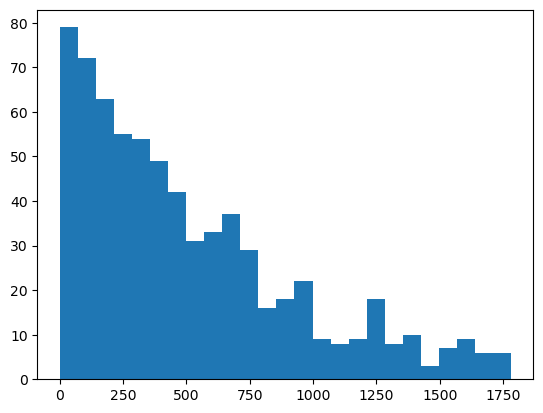

In [164]:
percentile901 = np.percentile(list(Counter(tokenized1_example).values()),90)
plt.hist([v for v in Counter(tokenized1_example).values() if v<=percentile901],bins=25)
plt.show()

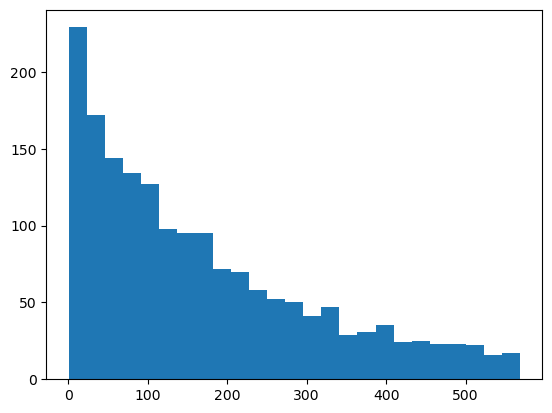

In [163]:
percentile902 = np.percentile(list(Counter(tokenized2_example).values()),90)
plt.hist([v for v in Counter(tokenized2_example).values() if v<=percentile902],bins=25)
plt.show()

In [327]:
vector_length = 48
max_vectors = 768
n_vectors = 768
n_sub_vectors = 64
postionals = np.array([[np.sin(j) if idx%2==0 else np.cos(j) for idx,j in enumerate(i*2*np.pi*np.arange(vector_length)/(vector_length-1))] for i in range(max_vectors)])/np.sqrt(vector_length)+1
sample_vectors = np.random.randn(n_vectors,vector_length)

0.5772216203414489
0.5824344374736952
0.5567855225640393


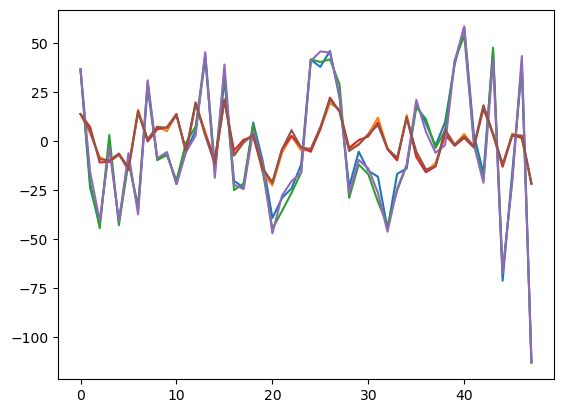

In [347]:

for _ in range(3):
    combined_vector = np.zeros(vector_length)
    for idx,p in zip(np.random.permutation(n_vectors),postionals):
        sv = sample_vectors[idx]
        combined_vector += sv*p
    plt.plot(combined_vector)
    combined_vector2 = np.zeros(vector_length)
    for idx,p in zip(np.random.permutation(n_sub_vectors),postionals):
        sv = sample_vectors[sample_vectors.var(axis=1).argsort()[-n_sub_vectors:]][idx]
        combined_vector2 += sv*p
    plt.plot(combined_vector2)
    print(cosine(combined_vector,combined_vector2))
plt.show()


In [278]:
from scipy.spatial.distance import cosine

In [340]:
cosine(combined_vector,np.random.randn(48))

0.9995948474093761

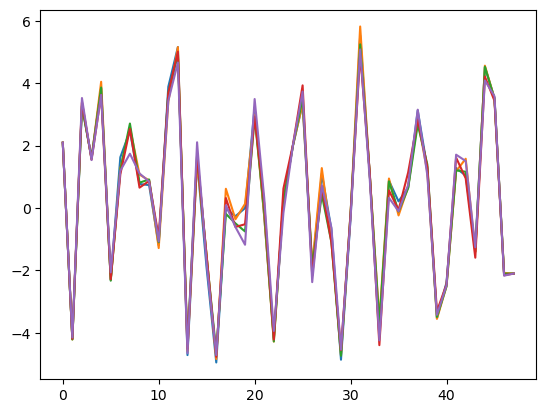

In [ ]:

plt.show()

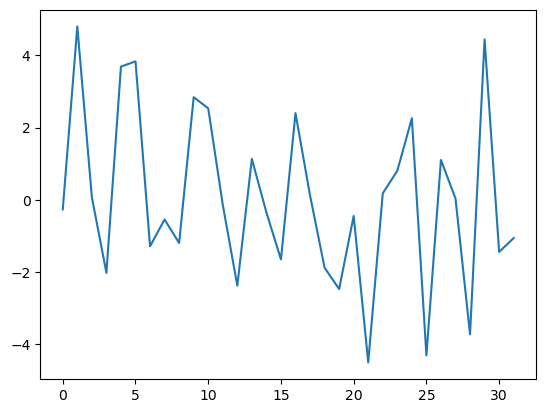

In [198]:
combined_vector = np.zeros(vector_length)
for sv,p in zip(np.vstack((sample_vectors[1:],sample_vectors[:1])),postionals):
    combined_vector += sv*p
plt.plot(combined_vector)

In [99]:
def create_position_vector(p,n):
    return np.sin(p*2*np.pi*np.arange(n)/(n-1))/np.sqrt(n)

In [100]:
import matplotlib.pyplot as plt

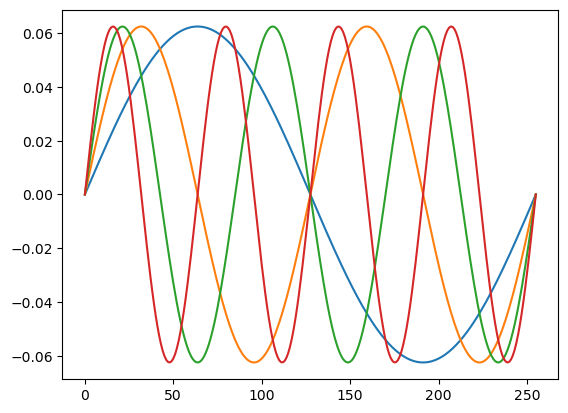

In [101]:
for i in range(1,5):
    plt.plot(create_position_vector(i,256))
plt.show()

In [84]:
first100_docs_tokens

[' patriarchal blessings',
 ' patriarchal blessing',
 ' of the ',
 ' of the priesthood ',
 'of the ',
 's of the ',
 'lease manifest it',
 'in the ',
 ' in the ',
 ' the priesthood ',
 ', and ',
 's and ',
 'e of the ',
 'e and ',
 'e the ',
 ' that ',
 's, and ',
 ' patriarchal bl',
 'to the ',
 't the ',
 ' to the ',
 'd the ',
 'ing the ',
 's the ',
 ' the L',
 'e of ',
 ' and ',
 ' the ',
 's of ',
 'that ',
 's to ',
 'e to ',
 'e priesthood ',
 ' language of ',
 ' the p',
 'ather',
 ' the w',
 ' our ',
 ' that',
 'f the ',
 ' the s',
 'ation',
 'other',
 't of ',
 'o the ',
 ' and s',
 ' and the ',
 ' the S',
 'n the ',
 'es and ',
 'this ',
 ', the ',
 'd to ',
 'your ',
 'e the',
 'e in ',
 ' for ',
 ' with ',
 'ed to ',
 'es of ',
 'with ',
 't of the ',
 ' the',
 'our ',
 'the ',
 'and ',
 'ith ',
 ' in ',
 ' to ',
 'ing ',
 ' and',
 ' of ',
 'ting ',
 't to ',
 'for ',
 ' we ',
 'ther',
 'are ',
 ' is ',
 'rist',
 's that ',
 'e that ',
 'ther ',
 'tion',
 'ent ',
 'e th',


In [49]:
reordered_combined_tokens = list(np.array(combined_tokens)[np.argsort(token_scores)[::-1]])

In [55]:
reordered_combined_tokens_refined = [t for t in reordered_combined_tokens if len(t)==1 or len(t)>12 or len([t_set for t_set in tokens if t in t_set])>1]

In [74]:
reordered_combined_tokens_refined

[' of the ',
 'e of the ',
 ', and ',
 'of the ',
 ' in the ',
 's and ',
 'in the ',
 ' the ',
 ' and ',
 's of the ',
 'e and ',
 'e in the ',
 's of ',
 's, and ',
 'es and ',
 'e of ',
 ' to the ',
 'the testi',
 ' you can ',
 ' that ',
 'e the ',
 's the ',
 'to the ',
 'and the ',
 'the ',
 'e to ',
 ' the L',
 'd the ',
 'ing ',
 ' of ',
 'and ',
 't the ',
 'ed to ',
 ' to ',
 's to ',
 'on the ',
 ' their ',
 ' is the ',
 ' the tem',
 'our ',
 'that ',
 ' the p',
 'es of ',
 ' the',
 'ather',
 'ation',
 ' the s',
 ' our ',
 'other',
 'd, and ',
 ' and',
 'this ',
 'd to ',
 'f the ',
 ' the S',
 'ather ',
 ', the ',
 'd and ',
 'n the ',
 ' in ',
 't of ',
 ' will ',
 ' the w',
 ' and s',
 'your ',
 'ing to ',
 ' and ev',
 'ed the ',
 'ant to ',
 'the Lor',
 'venants',
 's that ',
 'th and ',
 'in our ',
 'e, and ',
 'e will ',
 'with ',
 ' you ',
 'o the ',
 'ation ',
 'se of ',
 'ith ',
 'ring ',
 ' we ',
 'are ',
 'ent ',
 'ther',
 'ther ',
 'there ',
 'lation',
 'y the ',


In [13]:
len(example_doc.split(' '))

8175139

In [5]:
tokenized = tokenize_from_ranks(example_doc[:100000],tokens)
tokens_refined = [t for t in tokens if Counter(tokenized)[t]>4 or len(t)==1]
tokenized = tokenize_from_ranks(example_doc[:100000],tokens_refined)

In [6]:
len(tokens_refined)

1307

In [221]:
len(tokenized)*np.log(len(tokens_refined))/np.log(2)+8*sum([len(t) for t in tokens_refined])

374350.3877167608

In [213]:
len(tokenized)

32381

In [8]:
import matplotlib.pyplot as plt

In [9]:
len([t for t,v in Counter(tokenized).items() if v==5])

60

(array([  7.,  64., 193., 113., 167.,  95., 109.,  68.,  47.,  58.,  34.,
         38.,  23.,  36.,  18.,  19.,  15.,  16.,  18.,   4.,  18.,   9.,
          8.,   7.,  11.,   3.,   5.,   7.,   6.,   4.,   7.,   3.,   4.,
          1.,   3.,   4.,   5.,   1.,   4.,   2.,   7.,   2.,   1.,   3.,
          3.,   1.,   1.,   2.,   0.,   1.,   1.,   1.,   0.,   5.,   5.,
          1.,   2.,   1.,   2.,   2.,   1.,   3.,   1.,   0.,   1.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  1.  ,   3.44,   5.88,   8.32,  10.76,  13.2 ,  15.64,  18.08,
         20.52,  22.96,  25.4 ,  27.84,  30.28,  32.72,  35.16,  37.6 ,
         40.04,  42.48,  44.92,  47.36,  49.8 ,  52.24,  54.68,  57.12,
         59.56,  62.  ,  64.44,  66.88,  69.32,  71.76,  74.2 ,  76.64,
         79.08,  81.52,  83.96

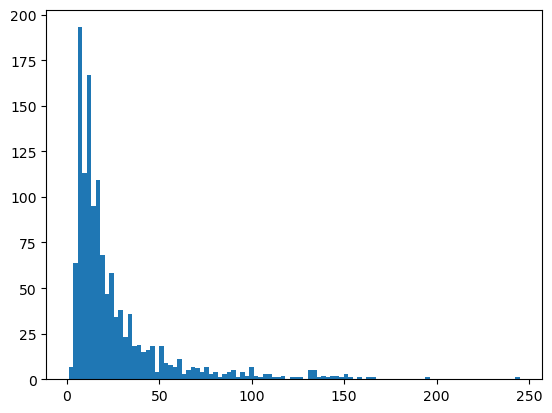

In [11]:
plt.hist(list(Counter(tokenized).values()),bins=100)

In [43]:
[np.array([1,2,3]),np.array([5,4])]+[np.array([idx]) for idx in range(arr.max()+1)]

[array([1, 2, 3]),
 array([5, 4]),
 array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [49]:
tokenize_from_ranks(arr,[np.array([idx]) for idx in range(arr.max()+1)])

[1,
 2,
 3,
 4,
 5,
 6,
 1,
 2,
 3,
 4,
 3,
 5,
 1,
 2,
 3,
 5,
 4,
 1,
 6,
 7,
 5,
 4,
 9,
 0,
 7,
 2,
 5,
 4,
 6,
 3,
 2,
 3,
 1,
 5,
 4,
 1,
 2,
 3]

In [23]:
# Create an array
arr = np.array([1, 2, 3, 4, 5, 6, 1, 2, 3,4,3,5,1,2,3,5,4,1,6,7,5,4,9,0,7,2,5,4,6,3,2,3,1,5,4,1,2,3])

# Define the sub-array to split on
sub_array = np.array([1,2,3])

# Find indices of the sub-array
indices = np.where(np.all(np.lib.stride_tricks.sliding_window_view(arr, len(sub_array)) == sub_array, axis=1))[0]

# Split the array based on the indices
split_arrays = np.split(arr, indices)

print(split_arrays)

[array([], dtype=int32), array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 3, 5]), array([1, 2, 3, 5, 4, 1, 6, 7, 5, 4, 9, 0, 7, 2, 5, 4, 6, 3, 2, 3, 1, 5,
       4]), array([1, 2, 3])]


In [18]:
list(arr)

[1,
 2,
 3,
 4,
 5,
 6,
 1,
 2,
 3,
 4,
 3,
 5,
 1,
 2,
 3,
 5,
 4,
 1,
 6,
 7,
 5,
 4,
 9,
 0,
 7,
 2,
 5,
 4,
 6,
 3,
 2,
 3,
 1,
 5,
 4,
 1,
 2,
 3]